In [1]:
import sys
sys.path.append('/workspace/visual_place_recognition/datasets')
import netvlad
import autox as dataset
from torch.utils.data import DataLoader

import torch
import numpy as np
from sklearn.neighbors import NearestNeighbors
from PIL import Image
import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
net = netvlad.create_model()
train_set = dataset.get_train_set()
train_set.update_subcache()

===> Building model


In [7]:
q = 0

qidx = train_set.qIdx[q]
# print(f'qidx: {qidx}')
cached_pidx = train_set.pIdx[qidx]
cached_nidx = train_set.nIdx[qidx]
# print(f'cached_pidx: {cached_pidx}, cached_nidx: {cached_nidx}')
pidx = np.where(np.in1d(train_set.Ranks[q,:], cached_pidx))[0]
nidx = np.where(np.in1d(train_set.Ranks[q,:], cached_nidx))[0]
# print(f'pidx: {pidx} nidx: {nidx}')
# print(f'{train_set.Ranks[q, nidx]}')
dPos = train_set.Scores[q, pidx][0]
# print(f'dPose: {dPos}')
dNeg = train_set.Scores[q, nidx]
dNegRank = train_set.Ranks[q, nidx]
# # # print(f'dNeg: {dNeg}')`
# # # how much are they violating
loss = dPos - dNeg + 0.1**0.5
violatingNeg = 0 < loss

# # # print(f'loss: {loss}')
# # print(np.sum(violatingNeg))

# # # # # select hardest negatives
hardest_negIdx = np.argsort(loss)[0:5]
# print(f'hardest_negIdx: {hardest_negIdx}')

# # # # # select the hardest negatives
cached_hardestNeg = dNegRank[hardest_negIdx]
print(f'qidx: {qidx}, pidx: {cached_pidx}, hardestNeg: {cached_hardestNeg}')

qidx: 0, pidx: [6 7 5 8 4 9 3], hardestNeg: [19 20 25 23 21]


In [3]:
print(f'triplets size: {len(train_set.triplets)}')

triplets size: 733


[550, 561, 717, 634, 679, 413, 376]


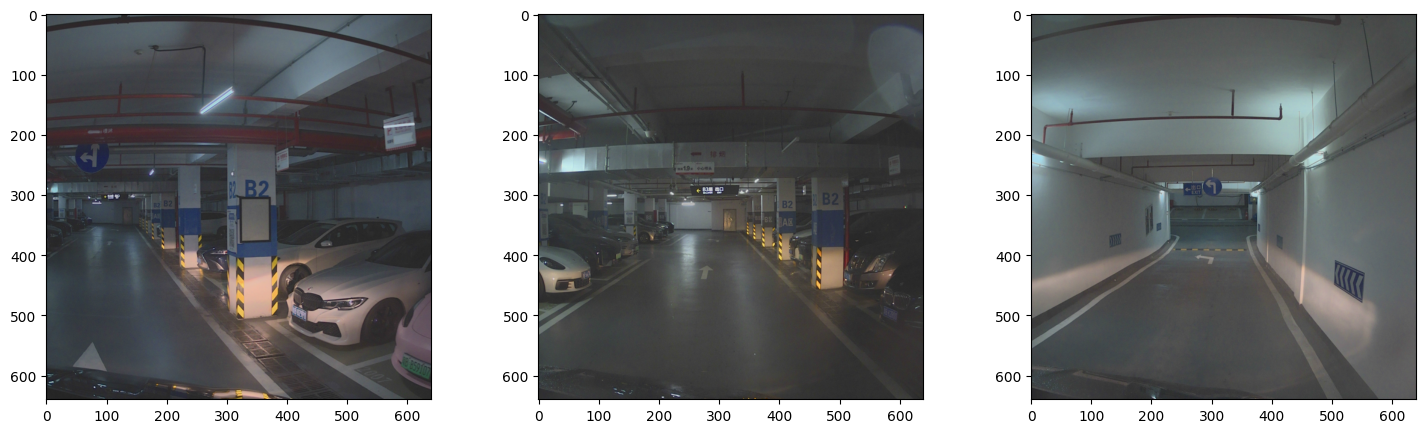

In [12]:
# plot qimage dbimage pimage
i = 550
print(train_set.triplets[i])
qImage = Image.open(train_set.qImages[train_set.triplets[i][0]]).resize((640,640))
pImage = Image.open(train_set.dbImages[train_set.triplets[i][1]]).resize((640,640))
nImage = Image.open(train_set.dbImages[train_set.triplets[i][2]]).resize((640,640))
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.imshow(qImage)
plt.subplot(1,3,2)
plt.imshow(pImage)
plt.subplot(1,3,3)
plt.imshow(nImage)
plt.show()

===> Building model


In [3]:
print(f'q_set size: {len(q_set)}, db_set: {len(db_set)} pIdx: {pIdx.shape}')

q_set size: 733, db_set: 748 pIdx: (733,)


In [10]:
query_data_loader = DataLoader(dataset=q_set, 
            num_workers=8, batch_size=128, shuffle=False, 
            pin_memory=True)

database_data_loader = DataLoader(dataset=db_set, 
            num_workers=8, batch_size=128, shuffle=False, 
            pin_memory=True)

net.eval()
with torch.no_grad():
    print('====> Extracting Features')
    pool_size = 512 * 64
    qFeat = np.empty((len(q_set), pool_size))
    dbFeat = np.empty((len(db_set), pool_size))

    for iteration, (input, indices) in enumerate(query_data_loader, 0):
        input = input.to('cuda')
        image_encoding = net.encoder(input)
        vlad_encoding = net.pool(image_encoding) 

        qFeat[indices.detach().numpy(), :] = vlad_encoding.detach().cpu().numpy()
        if iteration % 50 == 0 or len(query_data_loader) <= 10:
            print("==> Batch ({}/{})".format(iteration, 
                len(query_data_loader)), flush=True)

        del input, image_encoding, vlad_encoding

    for iteration, (input, indices) in enumerate(database_data_loader, 0):
        input = input.to('cuda')
        image_encoding = net.encoder(input)
        vlad_encoding = net.pool(image_encoding) 

        dbFeat[indices.detach().numpy(), :] = vlad_encoding.detach().cpu().numpy()
        if iteration % 50 == 0 or len(database_data_loader) <= 10:
            print("==> Batch ({}/{})".format(iteration, 
                len(database_data_loader)), flush=True)

        del input, image_encoding, vlad_encoding

del query_data_loader, database_data_loader

# extracted for both db and query, now split in own sets
qFeat = qFeat.astype('float32')
dbFeat = dbFeat.astype('float32')

====> Extracting Features
==> Batch (0/6)
==> Batch (1/6)
==> Batch (2/6)
==> Batch (3/6)
==> Batch (4/6)
==> Batch (5/6)
==> Batch (0/6)
==> Batch (1/6)
==> Batch (2/6)
==> Batch (3/6)
==> Batch (4/6)
==> Batch (5/6)


In [32]:
print(qFeat.shape, dbFeat.shape)
# find positive features for each query feature
posFeat = np.asarray([dbFeat[pIdx[i]] for i in range(len(pIdx))], dtype = object)

(733, 32768) (748, 32768)


In [35]:
nIdx = []
for pos in pIdx:
    nIdx.append(np.setdiff1d(np.arange(len(db_set)), pos, assume_unique=True))
    
nIdx = np.asarray(nIdx, dtype=object)

# negFeat = np.asarray([dbFeat[nIdx[i]] for i in range(10)], dtype=object)

# print(posFeat.shape, negFeat.shape)